In [1]:
%matplotlib inline

In [2]:
import datetime
import numpy as np 
import pandas as pd 
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt
import prettyplotlib as ppl
import brewer2mpl
import random
from operator import itemgetter
import time
import copy

In [3]:
set2 = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 16,
        }
plt.rc('font',family='serif')
plt.rc('font', size=16)
plt.rc('font', weight='bold')
plt.style.use('fivethirtyeight')
    
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 6 and height to 6
fig_size[0] = 6
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

### Load Data

In [17]:
train = pd.read_csv('data/act_train.csv', dtype={'people_id': np.str,
                               'activity_id': np.str,
                               'outcome': np.int8}, parse_dates=['date'])
test = pd.read_csv('data/act_test.csv', dtype={'people_id': np.str,
                              'activity_id': np.str}, parse_dates=['date'])
people = pd.read_csv('data/people.csv', dtype={'people_id': np.str,
                              'activity_id': np.str,
                              'char_38': np.int32},parse_dates=['date'])
df_train = pd.merge(train, people, on='people_id')
df_test = pd.merge(test, people, on='people_id')

In [18]:
train.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


In [19]:
test.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,type 1,type 7,type 4,NaN
1,ppl_100004,act2_230855,2022-07-20,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 682
2,ppl_10001,act1_240724,2022-10-14,type 1,type 12,type 1,type 5,type 4,type 6,type 1,type 1,type 13,type 10,NaN
3,ppl_10001,act1_83552,2022-11-27,type 1,type 20,type 10,type 5,type 4,type 6,type 1,type 1,type 5,type 5,NaN
4,ppl_10001,act2_1043301,2022-10-15,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 3015


In [20]:
people.head()

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,...,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,...,False,False,True,True,True,True,False,True,True,99
3,ppl_100004,type 2,group 22593,type 3,2022-07-20,type 40,type 25,type 9,type 4,type 16,...,True,True,True,True,True,True,True,True,True,76
4,ppl_100006,type 2,group 6534,type 3,2022-07-27,type 40,type 25,type 9,type 3,type 8,...,False,False,True,False,False,False,True,True,False,84


In [21]:
print("Process tables...")
for table in [train, test]:
        table['year'] = table['date'].dt.year
        table['month'] = table['date'].dt.month
        table['day'] = table['date'].dt.day
        table['day_of_week'] = table['date'].dt.dayofweek
        #table.drop('date', axis=1, inplace=True)
        table['activity_category'] = table['activity_category'].str.lstrip('type ').astype(np.int32)
        for i in range(1, 11):
            table['char_' + str(i)].fillna('type -999', inplace=True)
            table['char_' + str(i)] = table['char_' + str(i)].str.lstrip('type ').astype(np.int32)
people['year'] = people['date'].dt.year
people['month'] = people['date'].dt.month
people['day'] = people['date'].dt.day
people['day_of_week_people'] = people['date'].dt.dayofweek
#people.drop('date', axis=1, inplace=True)
people['group_1'] = people['group_1'].str.lstrip('group ').astype(np.int32)
for i in range(1, 10):
        people['char_' + str(i)] = people['char_' + str(i)].str.lstrip('type ').astype(np.int32)
for i in range(10, 38):
        people['char_' + str(i)] = people['char_' + str(i)].astype(np.int32)

print("Merge...")
train = pd.merge(train, people, how='left', on='people_id', left_index=True)
train.fillna(-999, inplace=True)
test = pd.merge(test, people, how='left', on='people_id', left_index=True)
test.fillna(-999, inplace=True)

Process tables...
Merge...


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2197291 entries, 0 to 189116
Data columns (total 61 columns):
people_id             object
activity_id           object
activity_category     int32
char_1_x              int32
char_2_x              int32
char_3_x              int32
char_4_x              int32
char_5_x              int32
char_6_x              int32
char_7_x              int32
char_8_x              int32
char_9_x              int32
char_10_x             int32
outcome               int8
year_x                int64
month_x               int64
day_x                 int64
day_of_week           int64
char_1_y              int32
group_1               int32
char_2_y              int32
char_3_y              int32
char_4_y              int32
char_5_y              int32
char_6_y              int32
char_7_y              int32
char_8_y              int32
char_9_y              int32
char_10_y             int32
char_11               int32
char_12               int32
char_13            

### Outcome Field 

In [22]:
plus = sum(train.loc[:, 'outcome'] == 0)
minus = sum(train.loc[:, 'outcome'] == 1)

print (plus, minus)
print (df_train['outcome'].unique())

1221794 975497
[0 1]


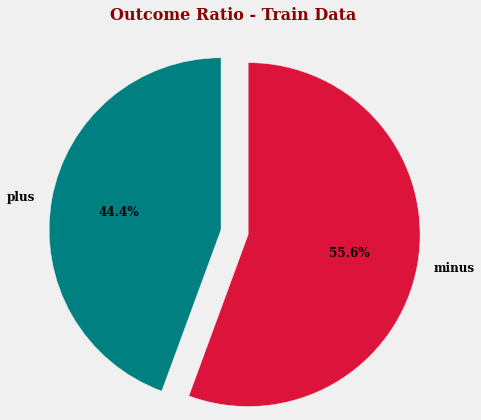

In [23]:
from matplotlib import rcParams
rcParams['font.size'] = 12
#print (rcParams.keys())
rcParams['text.color'] = 'black'

piechart = plt.pie(
    (minus, plus),
    labels=('plus', 'minus'),
    shadow=False,
    colors=('teal', 'crimson'),
    explode=(0.08,0.08), # space between slices 
    startangle=90,    # rotate conter-clockwise by 90 degrees
    autopct='%1.1f%%',# display fraction as percentages
)

plt.axis('equal')   
plt.title("Outcome Ratio - Train Data", y=1.08,fontdict=font)
plt.tight_layout()
plt.savefig('Outcome-train.png', bbox_inches='tight')

### Date Field 

In [24]:
for d in ['date_x', 'date_y']:
    print('Start of ' + d + ': ' + str(train[d].min().date()))
    print('  End of ' + d + ': ' + str(train[d].max().date()))
    print('Range of ' + d + ': ' + str(train[d].max() - train[d].min()) + '\n')

Start of date_x: 2022-07-17
  End of date_x: 2023-08-31
Range of date_x: 410 days 00:00:00

Start of date_y: 2020-05-18
  End of date_y: 2023-08-31
Range of date_y: 1200 days 00:00:00



In [13]:
train['date_x'].groupby(train.date_x.dt.date).count().plot(figsize=(10,5), label='Train')
test['date_x'].groupby(test.date_x.dt.date).count().plot(figsize=(10,5), label='Test')
plt.legend()
plt.show()

KeyError: 'date_x'

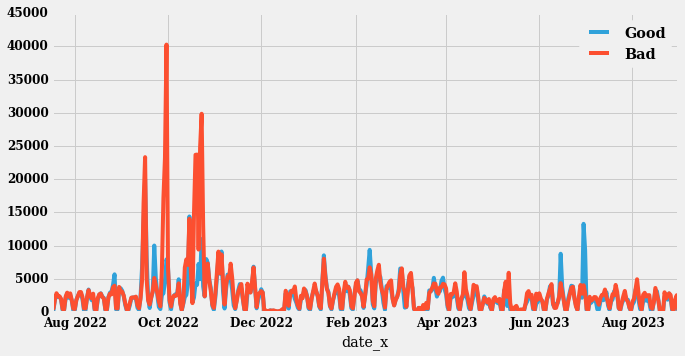

In [28]:
goods=train[train['outcome']==1]
bads=train[train['outcome']==0]

goods['date_x'].groupby(goods.date_x.dt.date).count().plot(figsize=(10,5),label='Good')
bads['date_x'].groupby(bads.date_x.dt.date).count().plot(figsize=(10,5),c='r',label='Bad')
plt.legend()
plt.show()

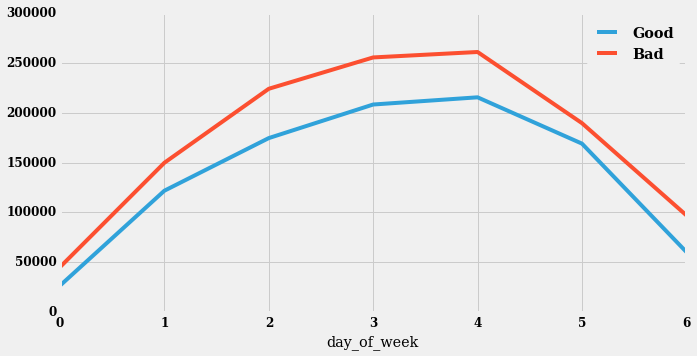

In [29]:
goods=train[train['outcome']==1]
bads=train[train['outcome']==0]

goods['day_of_week'].groupby(goods.day_of_week).count().plot(figsize=(10,5),label='Good')
bads['day_of_week'].groupby(bads.day_of_week).count().plot(figsize=(10,5),c='r',label='Bad')
plt.legend()
plt.show()

### Unique People 

In [17]:
nTotalUnq = len(people['people_id'].unique())
# Total people present in Training set
peopleTrain = train['people_id'].unique()
nTrainUnq = len(peopleTrain)

print('In total there are', nTotalUnq, 'people, of which', 
      nTrainUnq, '(', round(nTrainUnq/nTotalUnq*100), '%) are present in the training set.')

In total there are 189118 people, of which 151295 ( 80 %) are present in the training set.


In [18]:
# Total people present in test set
peopleTest = test['people_id'].unique()
nTestUnq = len(peopleTest)

print('In total there are', nTotalUnq, 'people, of which', 
      nTestUnq, '(', round(nTestUnq/nTotalUnq*100), '%) are present in the test set.')

In total there are 189118 people, of which 37823 ( 20 %) are present in the test set.


### Activity Type vs. Characteristics

In [31]:
train['activity_category'].describe()

count    2.197291e+06
mean     2.997433e+00
std      1.314068e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      7.000000e+00
Name: activity_category, dtype: float64

In [41]:
columns = train.columns
print(columns)

Index(['people_id', 'activity_id', 'date_x', 'activity_category', 'char_1_x',
       'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 'char_6_x', 'char_7_x',
       'char_8_x', 'char_9_x', 'char_10_x', 'outcome', 'year_x', 'month_x',
       'day_x', 'day_of_week', 'char_1_y', 'group_1', 'char_2_y', 'date_y',
       'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y',
       'char_9_y', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14',
       'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20',
       'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26',
       'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32',
       'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38',
       'year_y', 'month_y', 'day_y', 'day_of_week_people'],
      dtype='object')


In [50]:
characteristics = [x for x in columns if x.find('char_')!= -1]
print(characteristics)

['char_1_x', 'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x', 'char_1_y', 'char_2_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38']


/usr/local/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


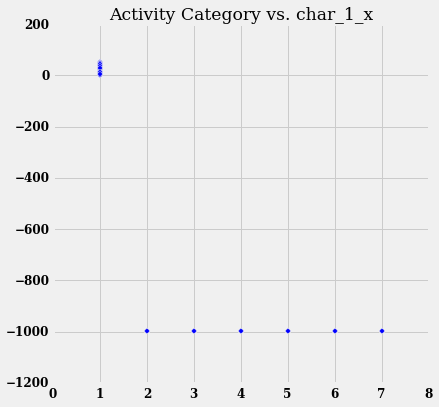

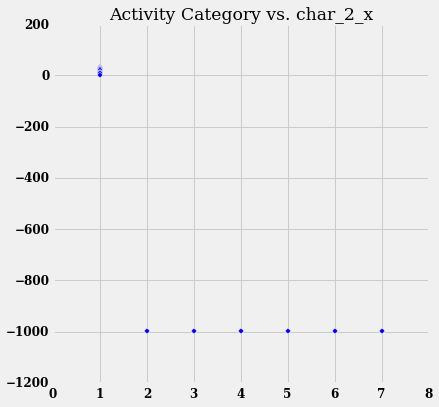

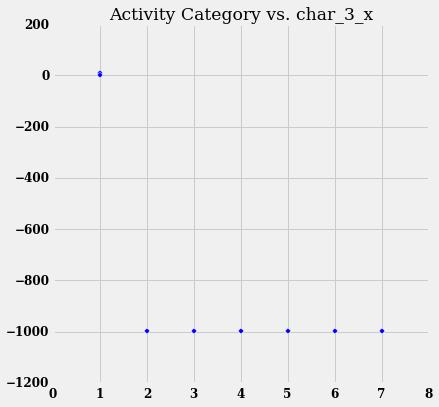

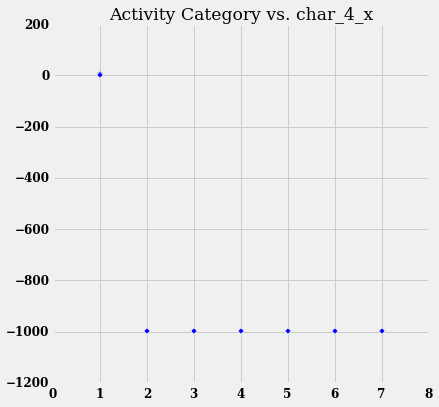

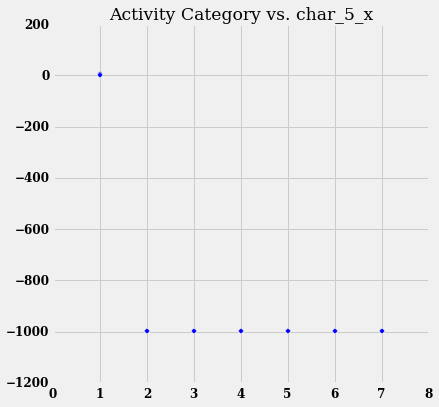

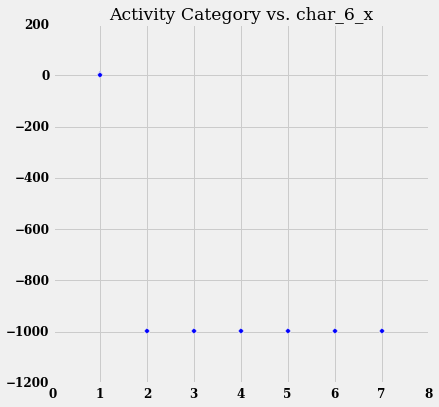

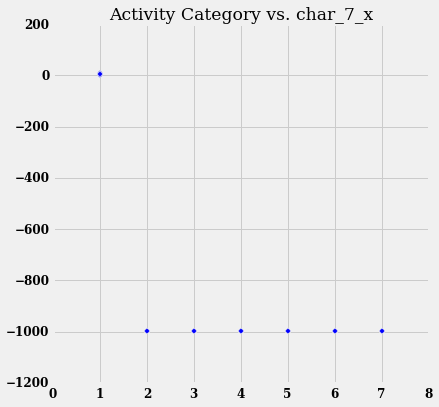

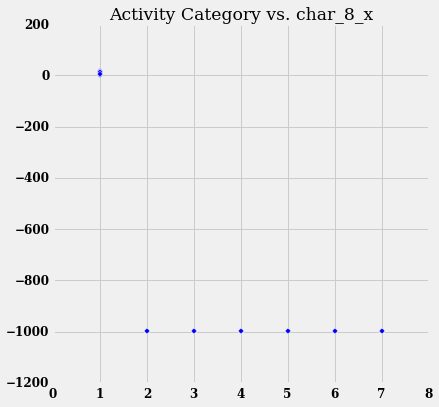

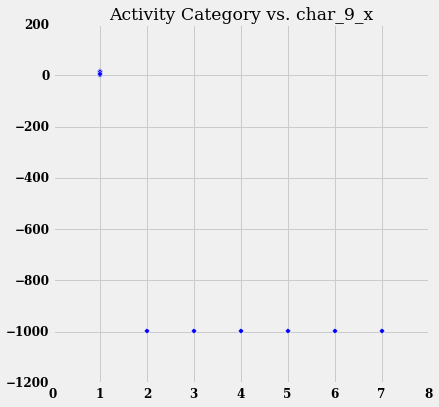

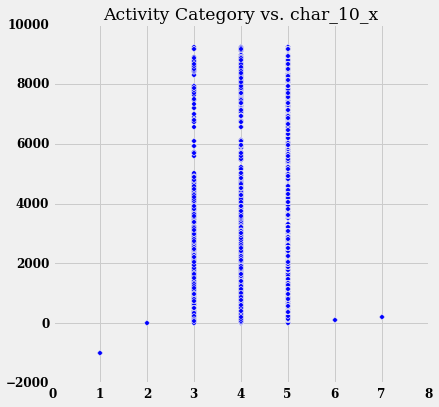

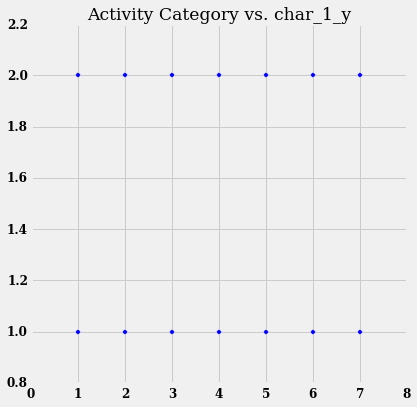

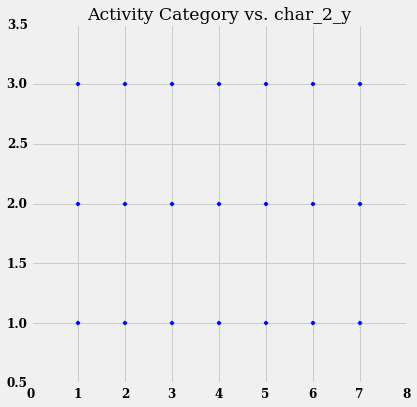

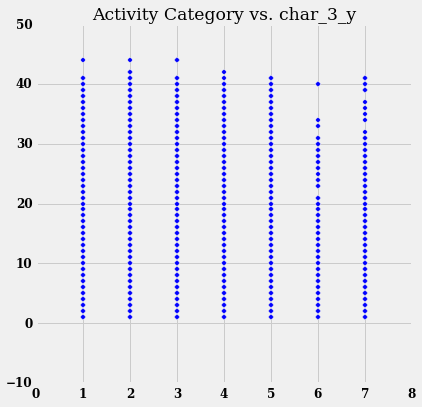

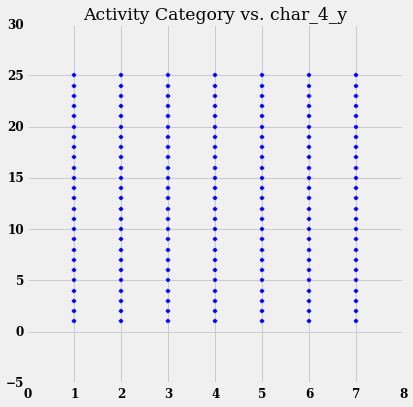

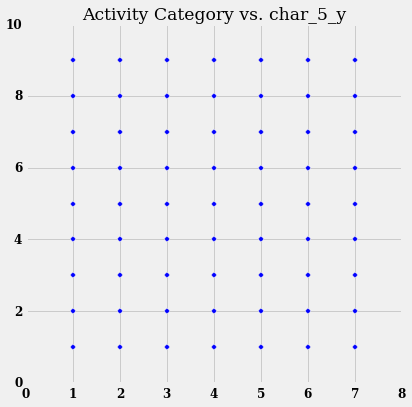

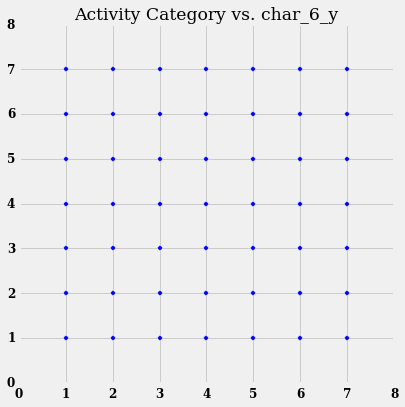

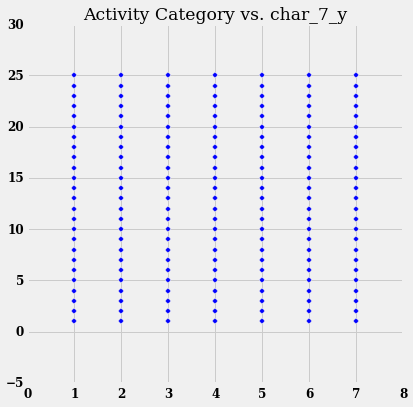

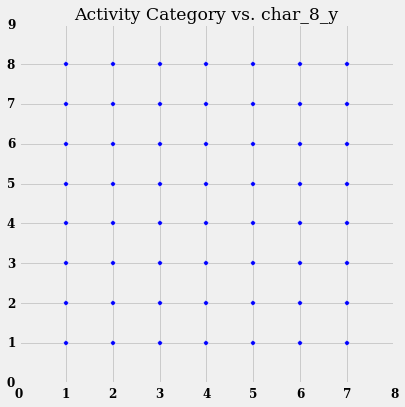

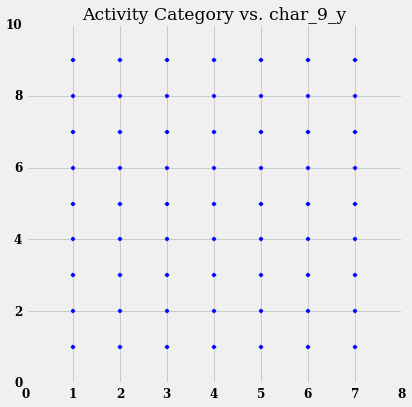

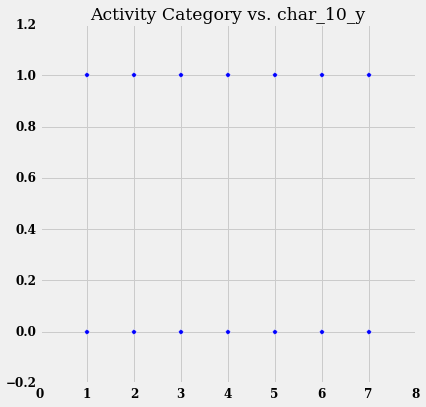

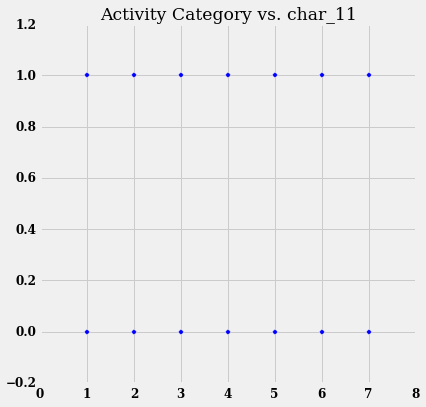

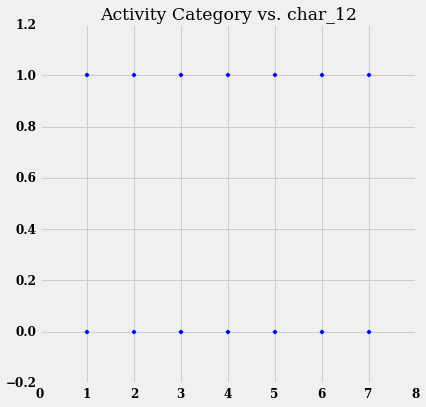

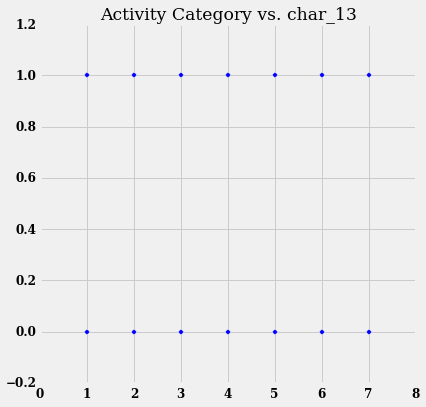

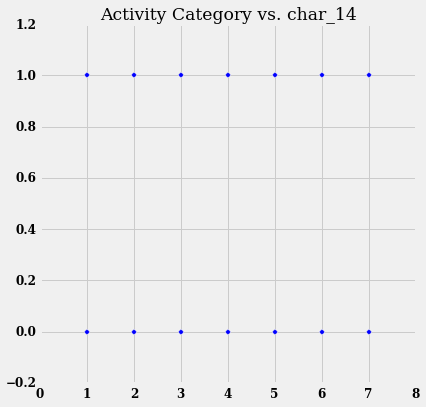

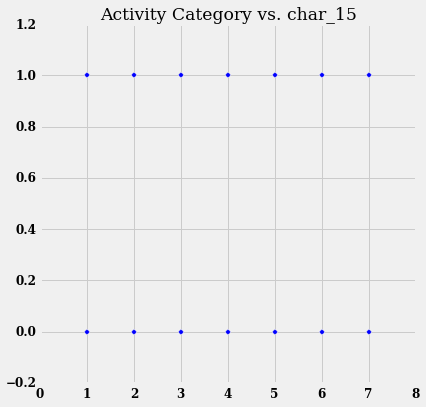

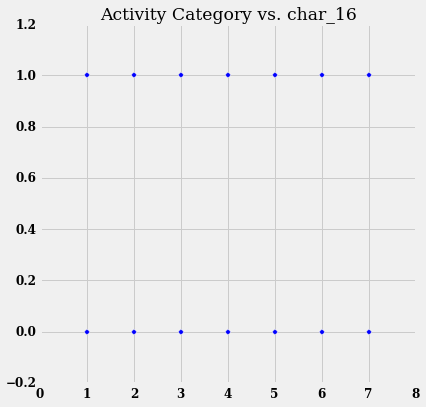

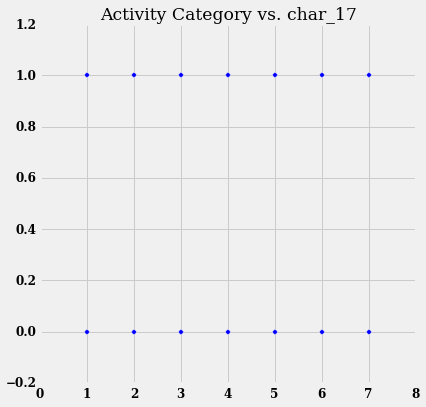

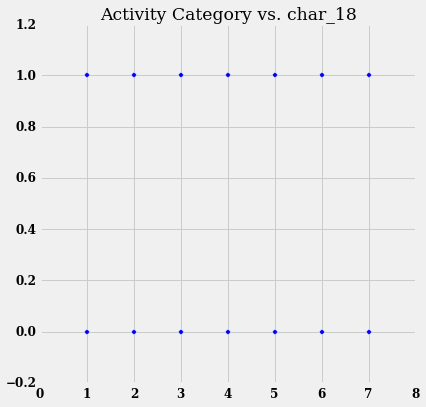

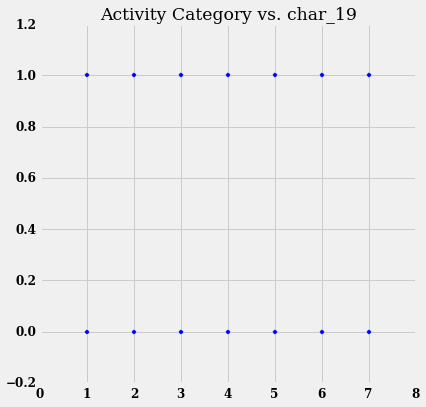

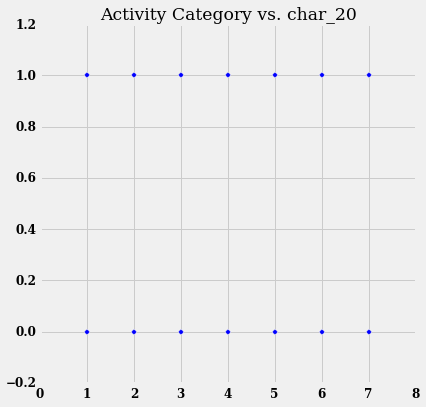

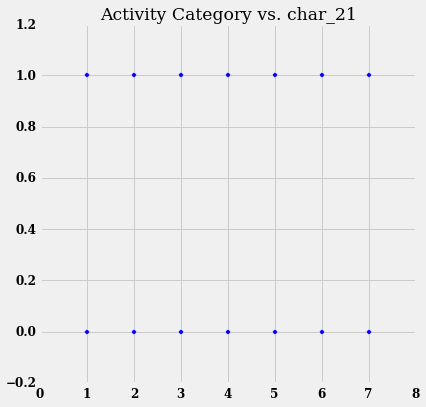

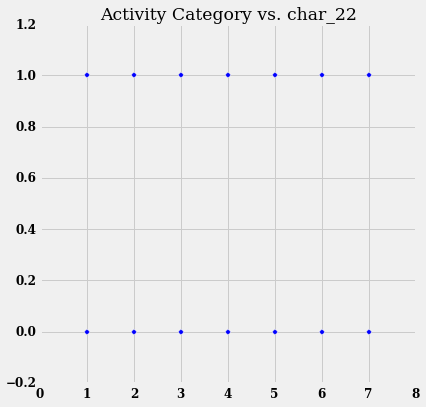

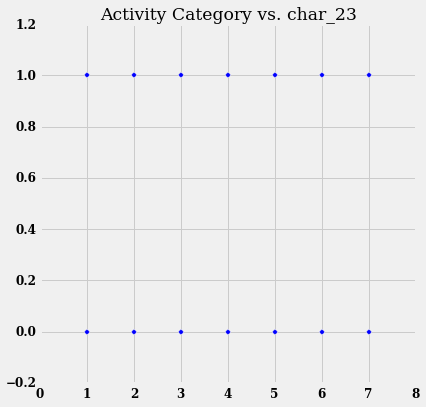

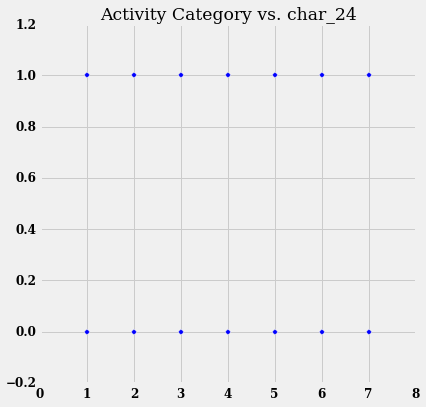

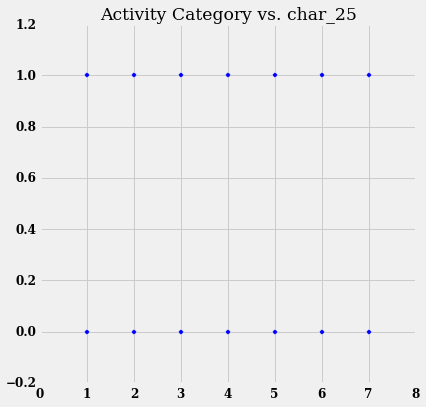

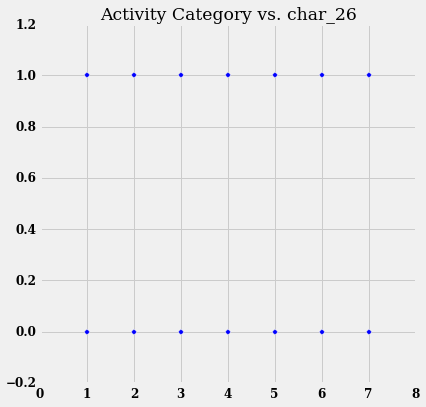

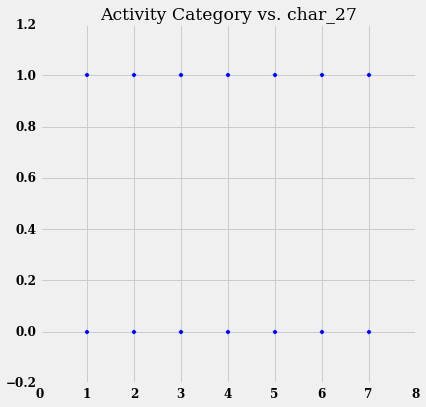

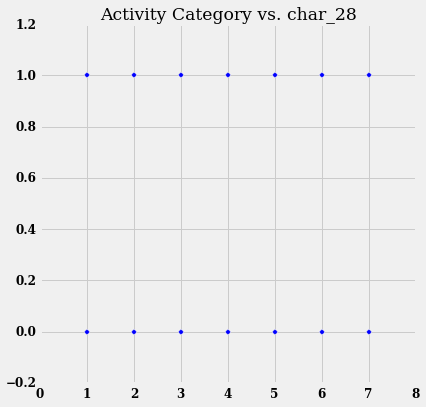

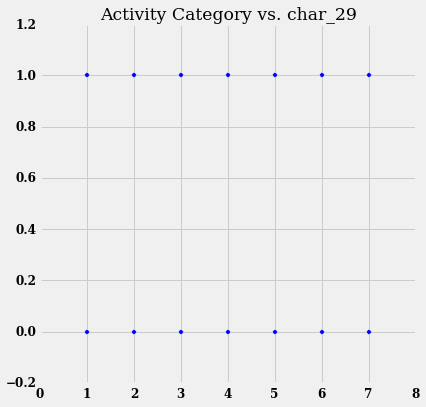

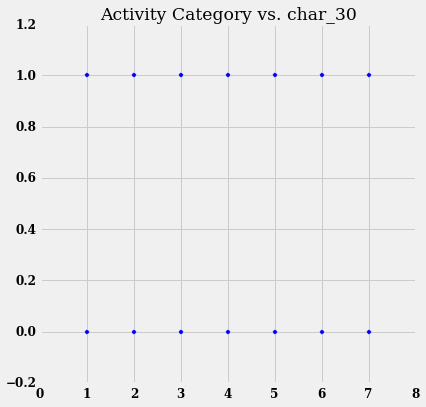

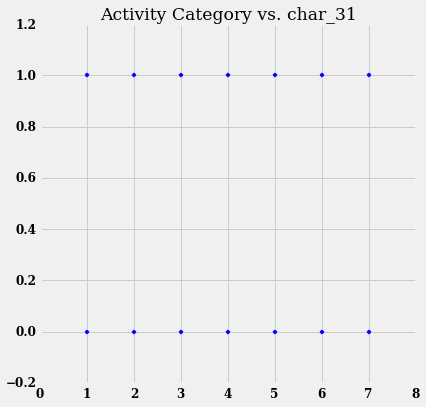

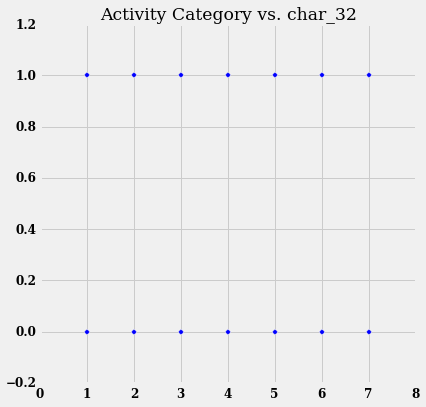

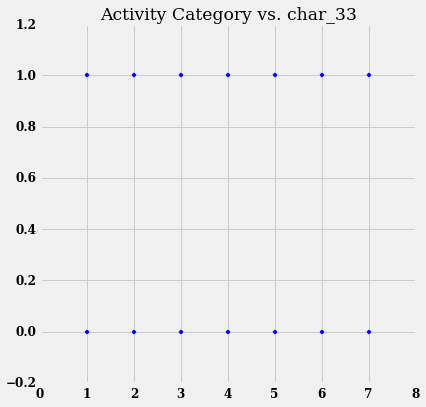

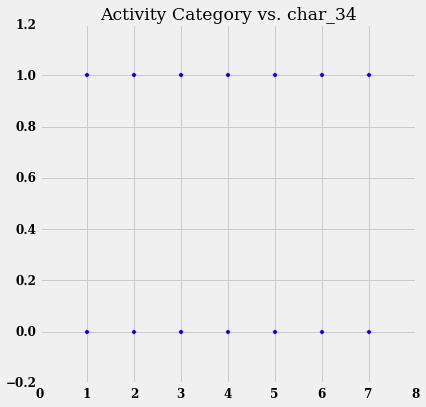

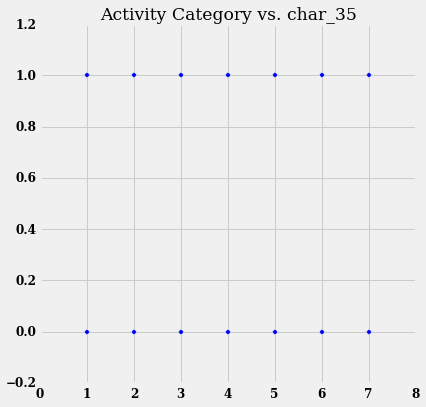

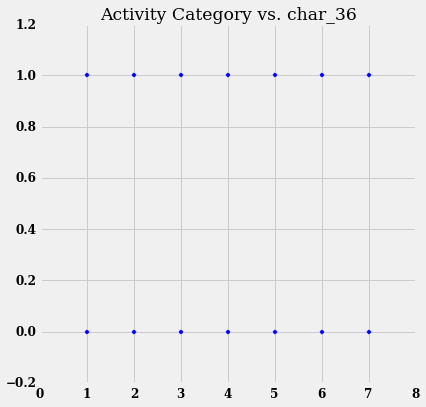

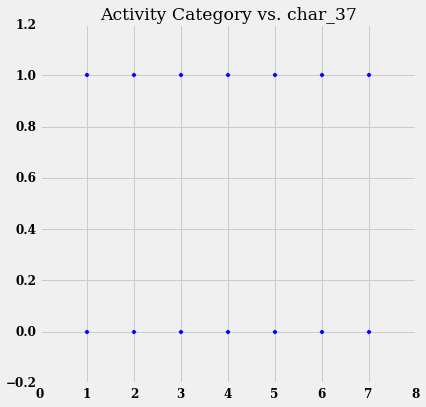

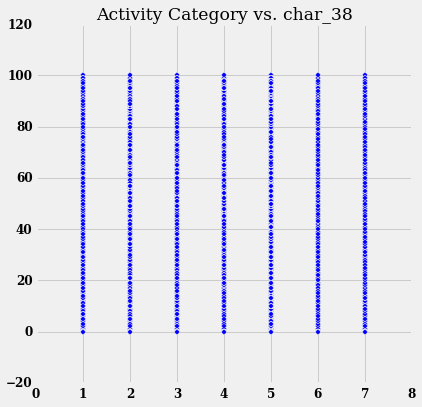

In [53]:
for i in characteristics:
    plt.scatter(train['activity_category'], train[i])
    plt.title("Activity Category vs. " + i)
    plt.show()

- Only Activity Type 1 is correlated with Char_1_x to Char_9_x
- Char_10_x seems to be useless for Activity Type 1
- Char_1_y to Char_10_y seems active for all Activity Types
- Char_11 to Char_37 seems active for all Activity Types

### Outcome vs. Activity Type

/usr/local/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


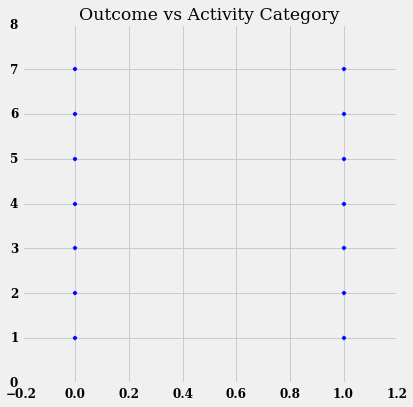

In [64]:
plt.scatter(train['outcome'], train['activity_category'])
plt.title("Outcome vs Activity Category")
plt.show()

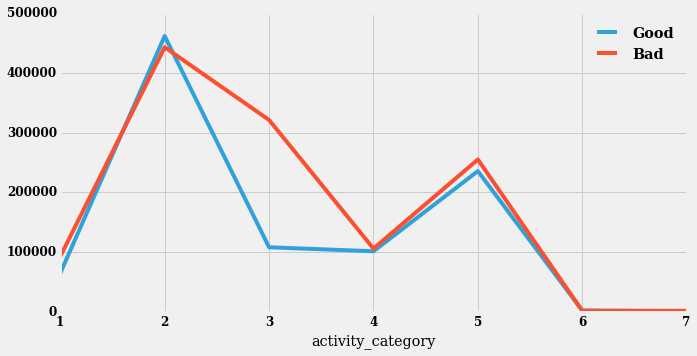

In [66]:
goods=train[train['outcome']==1]
bads=train[train['outcome']==0]
goods['activity_category'].groupby(goods.activity_category).count().plot(figsize=(10,5),label='Good')
bads['activity_category'].groupby(bads.activity_category).count().plot(figsize=(10,5),label='Bad')
plt.legend()
plt.show()

- Activity Type 3 looks like leads to lot of bad outcomes!
- Activity Type 2 seems to slightly biased towards good outcome 
- Activity Type 5 seems to slightly biased towards bad outcome
- Activity Type 6 & 7 seem to be very rare

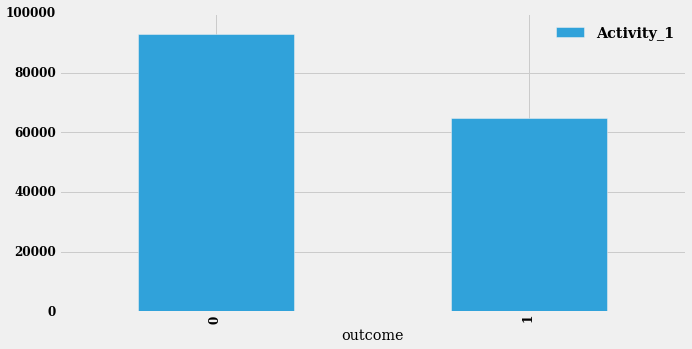

In [76]:
ac1=train[train['activity_category']==1]
ac1['outcome'].groupby(ac1.outcome).count().plot(figsize=(10,5),label='Activity_1', kind='bar')
plt.legend()
plt.show()

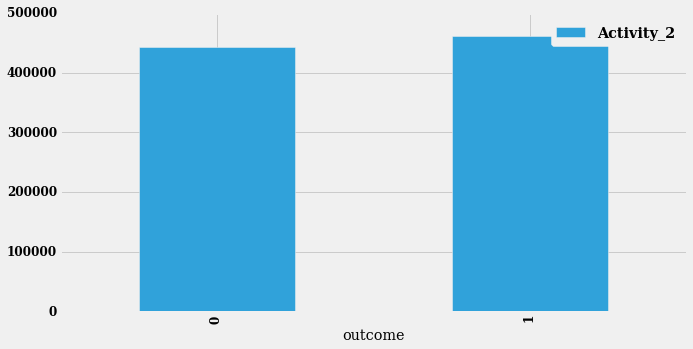

In [77]:
ac2=train[train['activity_category']==2]
ac2['outcome'].groupby(ac2.outcome).count().plot(figsize=(10,5),label='Activity_2', kind='bar')
plt.legend()
plt.show()

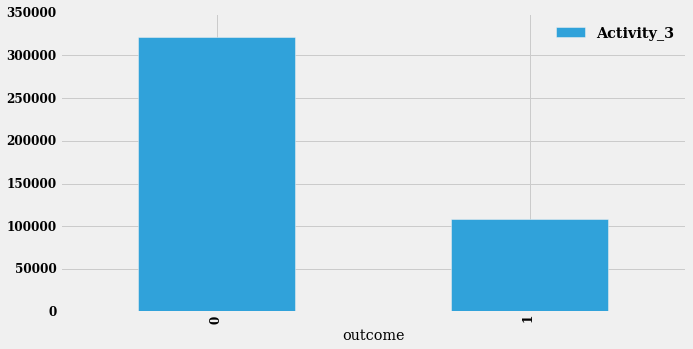

In [78]:
ac3=train[train['activity_category']==3]
ac3['outcome'].groupby(ac3.outcome).count().plot(figsize=(10,5),label='Activity_3', kind='bar')
plt.legend()
plt.show()

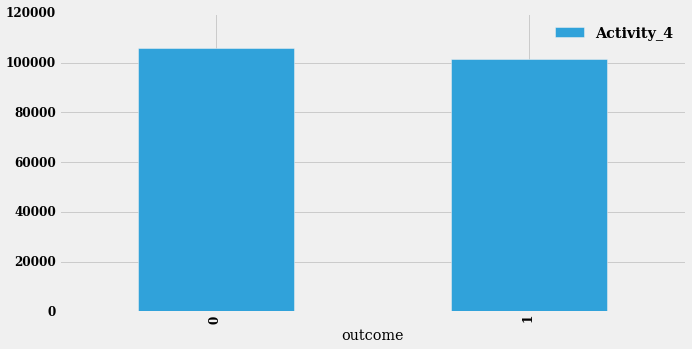

In [79]:
ac4=train[train['activity_category']==4]
ac4['outcome'].groupby(ac4.outcome).count().plot(figsize=(10,5),label='Activity_4', kind='bar')
plt.legend()
plt.show()

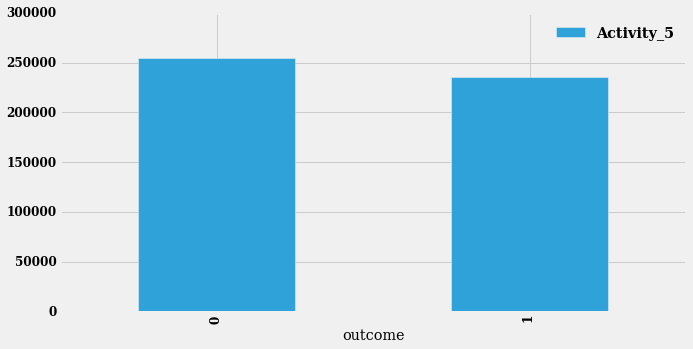

In [75]:
ac5=train[train['activity_category']==5]
ac5['outcome'].groupby(ac5.outcome).count().plot(figsize=(10,5),label='Activity_5', kind='bar')
plt.legend()
plt.show()

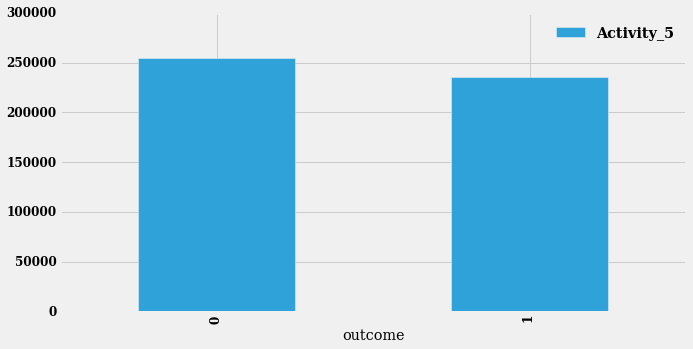

In [75]:
ac5=train[train['activity_category']==5]
ac5['outcome'].groupby(ac5.outcome).count().plot(figsize=(10,5),label='Activity_5', kind='bar')
plt.legend()
plt.show()

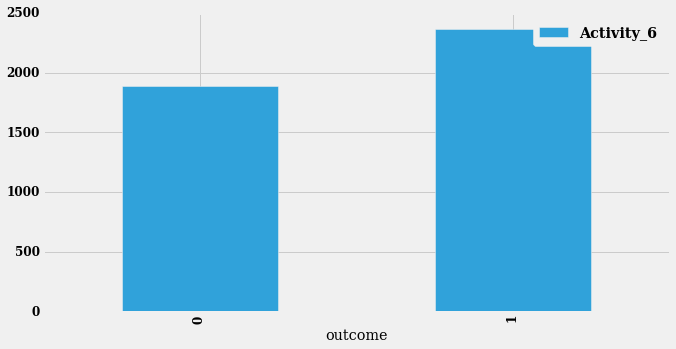

In [74]:
ac6=train[train['activity_category']==6]
ac6['outcome'].groupby(ac6.outcome).count().plot(figsize=(10,5),label='Activity_6', kind='bar')
plt.legend()
plt.show()

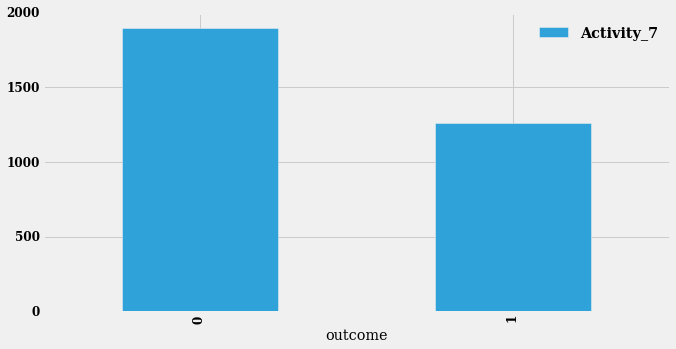

In [73]:
ac7=train[train['activity_category']==7]
ac7['outcome'].groupby(ac7.outcome).count().plot(figsize=(10,5),label='Activity_7', kind='bar')
plt.legend()
plt.show()